In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import copy
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import MDAnalysis as mda
import prolif
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

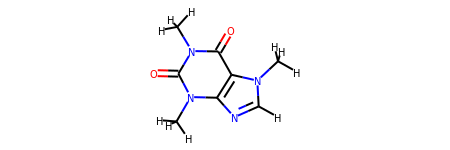

In [3]:
u = mda.Universe.from_smiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C", numConfs=5)
mol = u.atoms.convert_to("RDKIT")
mol

<prolif.molecule.Molecule with 1 residues and 24 atoms at 0x7f2f10035570>


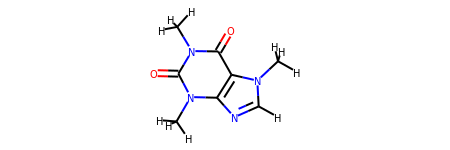

In [4]:
m = prolif.Molecule(mol)
print(repr(m))
m

In [5]:
m.residues

<prolif.residue.ResidueGroup with 1 residues at 0x7f2f8c537400>

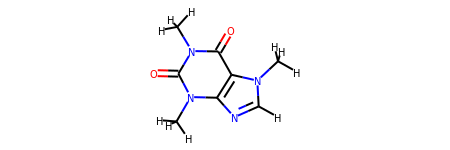

In [6]:
next(iter(m))

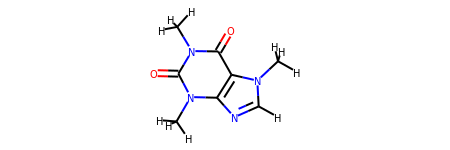

In [7]:
m["UNK1"]

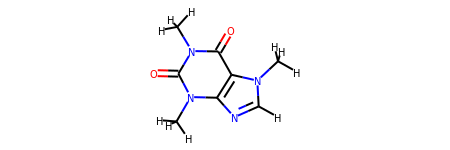

In [8]:
m[0]

# Trajectory

In [3]:
# load traj
u = mda.Universe(
    "/data/Projets/testdata/traj.pdb",
    "/data/Projets/testdata/traj.nc",
)
ag = u.select_atoms('protein or resname LIG')
ag

<AtomGroup with 4305 atoms>

In [4]:
" ".join([f"{r.resname}{r.resnum}" for r in ag.residues])

'ACE1 ILE2 PRO3 VAL4 GLN5 TYR6 LEU7 ARG8 TRP9 GLY10 ASP11 PRO12 GLU13 PRO14 ILE15 ALA16 ALA17 VAL18 VAL19 PHE20 ALA21 CYS22 LEU23 GLY24 LEU25 LEU26 ALA27 THR28 LEU29 PHE30 VAL31 THR32 VAL33 ILE34 PHE35 ILE36 ILE37 TYR38 ARG39 ASP40 THR41 PRO42 VAL43 VAL44 LYS45 SER46 SER47 SER48 ARG49 GLU50 LEU51 CYS52 TYR53 ILE54 ILE55 LEU56 ALA57 GLY58 ILE59 CYS60 LEU61 GLY62 TYR63 LEU64 CYS65 THR66 PHE67 CYS68 LEU69 ILE70 ALA71 LYS72 PRO73 LYS74 GLN75 ILE76 TYR77 CYX78 TYR79 LEU80 GLN81 ARG82 ILE83 GLY84 ILE85 GLY86 LEU87 SER88 PRO89 ALA90 MET91 SER92 TYR93 SER94 ALA95 LEU96 VAL97 THR98 LYS99 THR100 ASN101 ARG102 ILE103 ALA104 ARG105 ILE106 LEU107 ALA108 GLY109 SER110 LYS111 LYS112 LYS113 ILE114 CYS115 THR116 LYS117 LYS118 PRO119 ARG120 PHE121 MET122 SER123 ALA124 CYS125 ALA126 GLN127 LEU128 VAL129 ILE130 ALA131 PHE132 ILE133 LEU134 ILE135 CYS136 ILE137 GLN138 LEU139 GLY140 ILE141 ILE142 VAL143 ALA144 LEU145 PHE146 ILE147 MET148 GLU149 PRO150 PRO151 ASP152 ILE153 MET154 HIP155 ASP156 TYR157 PRO158 S

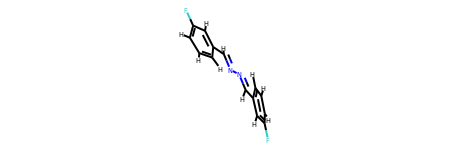

In [5]:
lig = ag.select_atoms("resname LIG")
prot = ag.select_atoms("protein")
prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
lig.convert_to("RDKIT")

In [12]:
mda._CONVERTERS["RDKIT"]._cache

{5362669377009719039: <rdkit.Chem.rdchem.Mol at 0x7f2f107c4d50>,
 5464953377291169094: <rdkit.Chem.rdchem.Mol at 0x7f2f10034f90>,
 3075731343586605215: <rdkit.Chem.rdchem.Mol at 0x7f2f10034d50>}

In [88]:
encoder = prolif.Encoder()
print(encoder)

cache = mda.coordinates.RDKit.RDKitConverter._cache
ifp = []

for ts in tqdm(u.trajectory[::5]):
    prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
    lig_mol = prolif.Molecule(lig.convert_to("RDKIT"))
    
    residues = prolif.get_pocket_residues(lig_mol, prot_mol)
    data = {"Frame": ts.frame}
    for res in residues:
        bs = encoder.run(lig_mol[0], prot_mol[res])
        if bs.sum() > 0:
            data[res] = bs
    ifp.append(data)

<prolif.encoder.Encoder: 8 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'PiStacking', 'Anionic', 'Cationic', 'CationPi', 'PiCation'] at 0x7f4944708160>


In [89]:
df = prolif.to_dataframe(ifp, encoder)
df

,Frame,ILE55.M,GLY58.M,ILE59.M,GLY62.M,ILE85.M,SER88.M,PRO89.M,SER92.M,TYR93.M,...,TYR226.M,PHE227.M,MET236.M,SER239.M,VAL240.M,SER243.M,ALA244.M,ALA247.M,CYS250.M,MET251.M
,,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,...,PiStacking,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic,Hydrophobic
0,0,0,1,1,0,1,1,1,1,0,...,1,0,0,0,1,1,1,0,0,0
1,5,1,0,1,0,1,0,1,1,1,...,0,0,0,1,1,1,0,1,0,0
2,10,0,1,1,1,1,1,1,1,1,...,0,0,1,0,0,1,1,1,0,0
3,15,0,1,1,1,1,1,1,1,0,...,1,0,1,0,1,1,1,1,0,0
4,20,1,1,1,0,0,0,1,1,1,...,0,0,0,1,1,1,0,1,0,0
5,25,0,1,1,0,0,1,1,1,1,...,0,0,0,1,1,1,1,1,0,0
6,30,0,1,1,1,1,1,1,0,1,...,0,1,1,0,1,1,1,0,0,0
7,35,1,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,1,1
8,40,0,1,1,0,1,0,1,0,1,...,0,0,1,0,0,1,1,1,0,0


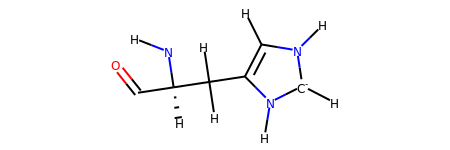

In [18]:
# [H]N[C@]([H])(C=O)C([H])([H])C1=C([H])N([H])[C-]([H])N1[H]
res = prot_mol["HIP155.M"]
res.RemoveAllConformers()
res

In [19]:
resid = prolif.ResidueId("ALA")
prot_mol[resid]

<prolif.residue.ResidueGroup with 22 residues at 0x7f0f26ce3160>

In [91]:
df.xs("HBAcceptor", level=1, axis=1)

,TYR93.M
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,0


In [90]:
df["TYR93.M"]

,Hydrophobic,HBAcceptor,PiStacking
0,0,0,0
1,1,0,0
2,1,0,1
3,0,0,0
4,1,0,1
5,1,1,0
6,1,0,0
7,1,0,0
8,1,0,0
9,1,0,0


In [92]:
from rdkit import DataStructs
bv = prolif.to_bitvectors(ifp, encoder)
DataStructs.TanimotoSimilarity(bv[0], bv[1])

0.375

In [43]:
# prot-prot interactions
encoder = prolif.Encoder(["Hydrophobic", "HBDonor", "HBAcceptor", 'PiStacking', 'Cationic'])
print(encoder)
ifp = []

for ts in tqdm(u.trajectory[::5]):   
    prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
    tm3 = prot_mol[75:105]
    others = prot_mol[[i for i in range(prot_mol.n_residues) if i < 70 or i >= 115]]

    data = {"Frame": ts.frame}
    for lresid, ligres in tm3.items():
        for presid, pres in others.items():
            bs = encoder.run(ligres, pres)
            if bs.sum() > 0:
                try:
                    previous = data[presid]
                except KeyError:
                    data[presid] = bs
                else:
                    data[presid] = previous | bs

    ifp.append(data)

ifp[0]

<prolif.encoder.Encoder: 5 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'PiStacking', 'Cationic'] at 0x7f4943b59490>


{'Frame': 0,
 CYS68.M: array([1, 1, 0, 0, 0], dtype=uint8),
 LEU165.M: array([1, 1, 0, 0, 0], dtype=uint8),
 ILE153.M: array([1, 0, 0, 0, 0], dtype=uint8),
 ILE166.M: array([1, 0, 0, 0, 0], dtype=uint8),
 CYX167.M: array([1, 0, 0, 0, 0], dtype=uint8),
 PHE146.M: array([1, 0, 0, 1, 0], dtype=uint8),
 PRO151.M: array([1, 0, 0, 0, 0], dtype=uint8),
 LEU69.M: array([1, 0, 0, 0, 0], dtype=uint8),
 ILE142.M: array([1, 0, 0, 0, 0], dtype=uint8),
 GLU149.M: array([0, 0, 0, 0, 1], dtype=uint8),
 THR169.M: array([0, 1, 0, 0, 0], dtype=uint8),
 GLY173.M: array([1, 0, 0, 0, 0], dtype=uint8),
 CYS65.M: array([1, 0, 0, 0, 0], dtype=uint8),
 LEU178.M: array([1, 0, 0, 0, 0], dtype=uint8),
 MET236.M: array([1, 0, 0, 0, 0], dtype=uint8),
 GLN138.M: array([1, 0, 0, 0, 0], dtype=uint8),
 PRO177.M: array([1, 0, 0, 0, 0], dtype=uint8),
 ASN181.M: array([1, 0, 1, 0, 0], dtype=uint8),
 ILE135.M: array([1, 0, 0, 0, 0], dtype=uint8),
 LEU139.M: array([1, 0, 0, 0, 0], dtype=uint8),
 GLY58.M: array([1, 0, 0, 0, 0

In [44]:
df = prolif.to_dataframe(ifp, encoder)
df

Frame      ACE1.M      ILE2.M            SER46.M     SER47.M          \
         Hydrophobic Hydrophobic HBAcceptor HBDonor Hydrophobic HBDonor   
0      0           0           0          0       0           0       0   
1      5           0           0          0       0           0       0   
2     10           0           0          0       0           0       0   
3     15           0           0          0       0           0       0   
4     20           0           0          0       0           0       0   
5     25           1           0          0       0           1       0   
6     30           0           0          0       0           0       0   
7     35           0           0          0       0           0       0   
8     40           0           0          0       0           0       0   
9     45           0           0          0       1           0       1   
10    50           0           0          0       0           0       0   
11    55           0           0          0       0           0       0   
12    60           0           0          0       0           0       0   
13    65           1           1          0       0           0       0   
14    70           0           0          0       0           0       0   
15    75           1           1          1       1           1       0   
16    80           1           0          0       0           1       1   

       SER48.M             GLU50.M  ...    THR215.M            CYS216.M  \
   Hydrophobic HBDonor Hydrophobic  ... Hydrophobic HBDonor Hydrophobic   
0            1       1           0  ...           1       1           1   
1            0       1           0  ...           0       1           0   
2            0       0           0  ...           1       1           1   
3            1       1           0  ...           1       0           0   
4            1       0           0  ...           1       1           0   
5            0       0           0  ...           1       0           0   
6            1       1           0  ...           1       1           1   
7            1       1           1  ...           1       0           0   
8            0       0           0  ...           1       1           1   
9            0       0           0  ...           1       0           1   
10           1       0           0  ...           1       1           1   
11           0       1           0  ...           1       1           1   
12           0       0           0  ...           1       1           1   
13           1       0           0  ...           1       0           0   
14           0       0           0  ...           1       1           1   
15           1       1           0  ...           0       0           0   
16           1       1           0  ...           1       0           0   

      TRP219.M    PHE222.M    ILE233.M    MET236.M    CYS237.M    VAL240.M  \
   Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic   
0            1           0           0           1           0           0   
1            0           0           0           1           0           1   
2            1           0           0           1           0           1   
3            0           0           0           1           0           1   
4            1           0           1           1           1           1   
5            0           0           1           1           1           1   
6            0           0           0           1           0           1   
7            1           0           0           1           1           1   
8            0           0           0           1           0           0   
9            0           0           0           1           0           1   
10           0           0           0           0           0           1   
11           0           0           0           1           0           1   
12           1           0           0           1         

In [45]:
bv = prolif.to_bitvectors(ifp, encoder)
DataStructs.BulkTanimotoSimilarity(bv[0], bv)

[1.0,
 0.5217391304347826,
 0.6176470588235294,
 0.5571428571428572,
 0.5394736842105263,
 0.5,
 0.5692307692307692,
 0.5131578947368421,
 0.5797101449275363,
 0.5217391304347826,
 0.578125,
 0.5441176470588235,
 0.5507246376811594,
 0.5285714285714286,
 0.5909090909090909,
 0.5066666666666667,
 0.5]

In [64]:
encoder = prolif.Encoder(["XBDonor", "HBDonor", "HBAcceptor", "PiCation", 'PiStacking'], return_atoms=True)
u.trajectory[0]
prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
lig_mol = prolif.Molecule(lig.convert_to("RDKIT"))
residues = prolif.get_pocket_residues(lig_mol, prot_mol)
ifp = {}
for res in residues:
    bs, ids = encoder.run(lig_mol[0], prot_mol[res])
    if bs.sum() > 0:
        ifp[res] = (bs, *(i for i in ids if i != (None, None)))
ifp

{PHE222.M: (array([0, 0, 0, 0, 1], dtype=uint8), (10, 714)),
 TYR226.M: (array([0, 0, 0, 0, 1], dtype=uint8), (10, 640))}

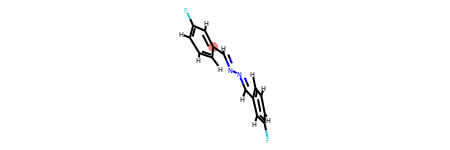

In [74]:
atom_idx = 10
mol = lig_mol

atom = mol.GetAtomWithIdx(atom_idx)
resid = prolif.ResidueId.from_atom(atom)
i = [a.GetIdx() for a in mol[resid].GetAtoms() if a.GetUnsignedProp("mapindex") == atom_idx][0]
mol[resid].__sssAtoms = [i]
mol[resid]

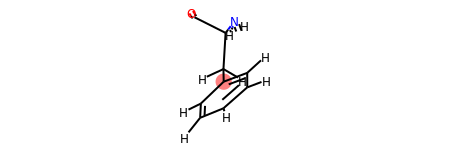

In [75]:
atom_idx = 714
mol = prot_mol

atom = mol.GetAtomWithIdx(atom_idx)
resid = prolif.ResidueId.from_atom(atom)
i = [a.GetIdx() for a in mol[resid].GetAtoms() if a.GetUnsignedProp("mapindex") == atom_idx][0]
mol[resid].__sssAtoms = [i]
mol[resid]

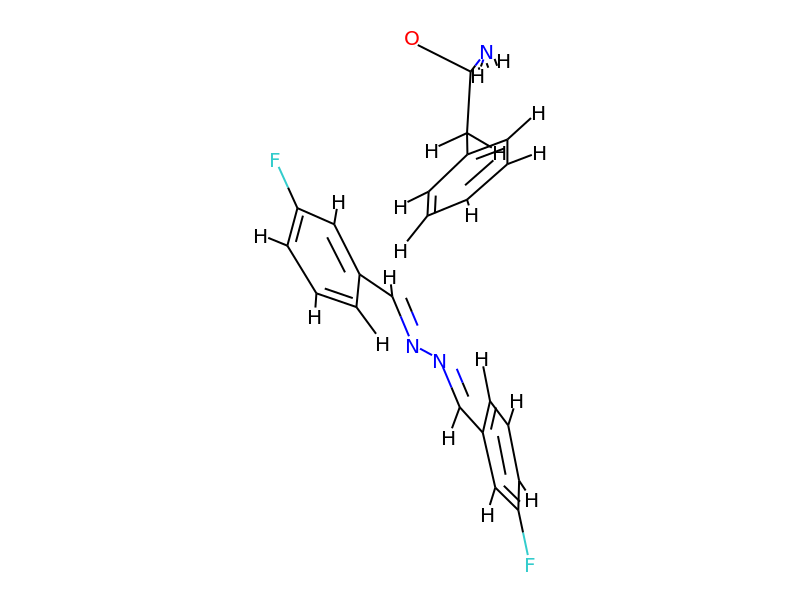

In [76]:
from rdkit.Chem import AllChem, Draw
mol = AllChem.CombineMols(prot_mol["PHE222.M"], lig_mol[0])
Draw.MolToImage(mol, size=(800,600))

In [86]:
class CloseContact(prolif.Interaction):
    def __init__(self, distance=2.0):
        self.distance = distance
    def detect(self, res1, res2):
        for a1 in res1.GetAtoms():
            p1 = res1.xyz[a1.GetIdx()]
            for a2 in res2.GetAtoms():
                p2 = res2.xyz[a2.GetIdx()]
                dist = np.linalg.norm(p1 - p2)
                if dist <= self.distance:
                    return True

encoder = prolif.Encoder(["Hydrophobic", "CloseContact"])
encoder.run(lig_mol[0], prot_mol["PHE222.M"])

[True, None]

In [94]:
encoder = prolif.Encoder(["HBAcceptor", "XBDonor", "FaceToFace", "EdgeToFace"])
ifp = []
for ts in tqdm(u.trajectory):    
    prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
    lig_mol = prolif.Molecule(lig.convert_to("RDKIT"))
    
    residues = prolif.get_pocket_residues(lig_mol, prot_mol)
    data = {"Frame": ts.frame}
    for res in residues:
        bs = encoder.run(lig_mol[0], prot_mol[res])
        if bs.sum() > 0:
            data[res] = bs
    ifp.append(data)

df = prolif.to_dataframe(ifp, encoder)
df.shape

(85, 10)

Removed  - present in less than 1% of interactions


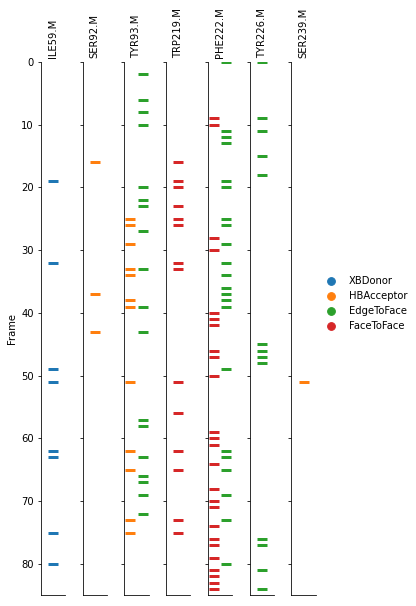

In [95]:
data = pd.melt(df, id_vars=["Frame"], var_name=["residue","interaction"])
data = data[data["value"] != 0]
data.reset_index(inplace=True, drop=True)
# remove residues appearing less than 1% of the time
t = data.groupby(["residue","interaction"], as_index=False).agg({"value":"count"}).groupby("residue", as_index=False).agg({"value":"max"})
threshold = int(0.01*(data.Frame.max()+1))
todrop = t.loc[t["value"] < threshold].residue.tolist()
data = data[~data["residue"].isin(todrop)]
print("Removed", ", ".join(todrop), "- present in less than 1% of interactions")

# plot
sns.set_context(font_scale=1.3)
g = sns.catplot(
    data=data, x="interaction", y="Frame", hue="interaction", col="residue",
    height=8, aspect=0.08, jitter=0, sharex=False, marker="_", s=10, linewidth=3,
)
g.set_titles("{col_name}", rotation=90)
g.set(xticks=[], ylim=(0,data.Frame.max()+1))
g.set_xticklabels([])
g.set_xlabels("")
g.add_legend()
for ax in g.axes.flat:
    ax.invert_yaxis()

In [ ]:
# old code

In [11]:
from math import pi
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, FactorRange, HoverTool, Legend, FixedTicker

In [12]:
# interactive plot
output_notebook()

data_bokeh = data.drop(columns="value").copy()
interactions = data_bokeh.interaction.unique()
colors = Category10.get(len(interactions))
residues = data_bokeh.residue.unique()
x_range = [(residue, interaction) for residue in residues for interaction in interactions]

renderers = []
legend_items = []
p = figure(x_range=FactorRange(*x_range), plot_width=900, plot_height=1800)
for i, (interaction, color) in enumerate(zip(interactions, colors)):
    d = data_bokeh.loc[data_bokeh["interaction"]==interaction]
    x = [(r,i) for r in d.residue]
    y = d["Frame"]
    r = p.dash(
        x=x, y=y, color=color,
        line_width=2, size=5, alpha=0.7, hover_alpha=1.0,
    )
    #renderers.append(r)
    legend_items.append((interaction,[r]))

p.add_tools(HoverTool(
    tooltips=[("Frame","@y")], mode='hline',
    #tooltips=None, renderers=renderers, mode='hline'
))
p.y_range.start = -1
p.y_range.end = data_bokeh.Frame.max()+1

p.ygrid.visible = False
p.xgrid.grid_line_alpha = 0.5
p.xgrid.ticker = p.xaxis[0].ticker
p.xaxis.group_label_orientation = pi/2
p.xaxis.major_label_text_color = None

p.add_layout(Legend(items=legend_items, click_policy="hide"), 'right')

show(p)

Loading BokehJS ...